## Телеком — задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. 

Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. 

Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг:

- Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

Описание полей данных:

- BeginDate – дата начала пользования услугами,
- EndDate – дата окончания пользования услугами,
- Type – тип оплаты: ежемесячный, годовой и тд,
- PaperlessBilling – безналичный расчет,
- PaymentMethod – способ оплаты,
- MonthlyCharges – ежемесячные траты на услуги,
- TotalCharges – всего потрачено денег на услуги
- Dependents – наличие иждивенцев
- Senior Citizen – наличие пенсионного статуса по возрасту
- Partner – наличие супруга(и)
- MultipleLines – наличие возможности ведения параллельных линий во время звонка
- 0 sp                      AUC-ROC < 0.75
- 4 sp          0.75 ≤ AUC-ROC < 0.81
- 4.5 sp    0.81 ≤ AUC-ROC < 0.85
- 5 sp       0.85 ≤ AUC-ROC < 0.87
- 5.5 sp    0.87 ≤ AUC-ROC < 0.88
- 6 sp                      AUC-ROC ≥ 0.88
- RANDOM_STATE = 121222

## Исследовательский анализ данных

#### Первичное знакомство / загрузка данных

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import phik

from catboost import CatBoostClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from phik import resources, report
import time

RANDOM_STATE=121222

In [2]:
# читаем данные из .csv файла с помощью метода read_csv()
try: 
    contract = pd.read_csv('D:\\python\\final_provider\\contract.csv')
    internet = pd.read_csv('D:\\python\\final_provider\\internet.csv')
    personal = pd.read_csv('D:\\python\\final_provider\\personal.csv')
    phone = pd.read_csv('D:\\python\\final_provider\\phone.csv')
except:
    contract = pd.read_csv('https://code.s3.yandex.net/datasets/final_provider/contract.csv')
    internet = pd.read_csv('https://code.s3.yandex.net/datasets/final_provider/internet.csv')
    personal = pd.read_csv('https://code.s3.yandex.net/datasets/final_provider/personal.csv')
    phone = pd.read_csv('https://code.s3.yandex.net/datasets/final_provider/phone.csv')

In [3]:
# с помощью метода info() изучим структуру таблицы: 
# типы данных, пропуски.
print('Информация о договоре - contract:')
display(contract.info())
print()

print('Информация об интернет-услугах - internet:')
display(internet.info())
print()

print('Персональные данные клиента - personal:')
display(personal.info())
print()

print('Информация об услугах телефонии - phone:')
display(phone.info())
print()

Информация о договоре - contract:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None


Информация об интернет-услугах - internet:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None


Персональные данные клиента - personal:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None


Информация об услугах телефонии - phone:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

In [4]:
# выведем первые 5 строк каждой таблицы с помощью метода head()
print('Информация о договоре - contract:')
display(contract.head())
print('Информация об интернет-услугах - internet:')
display(internet.head())
print('Персональные данные клиента - personal:')
display(personal.head())
print('Информация об услугах телефонии - phone:')
display(phone.head())

Информация о договоре - contract:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


Информация об интернет-услугах - internet:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Персональные данные клиента - personal:


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Информация об услугах телефонии - phone:


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


- Во всех таблицах необходимо привести наименования столбцов к змеиному регистру
- Все таблицы необходимо объединить по полю customer_id
- Количество строк в таблицах не совпадает
        contract - 7043
        internet - 5517
        personal - 7043
        phone -    6360
- в дальнейшем можно воспользоваться данной информацией, чтобы определить пользователей, кто не пользуется услугами internet или phone

### Информация о договоре - contract

In [5]:
contract.describe(include='all')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,5,3,2,4,NaN,6531
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5174,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


*Информация о договоре - contract:*
- Таблица содержит в себе информацию о 7043 контрактах
- BeginDate и EndDate необходимо привести к datetime
- Явных пропусков нет
- Поля type, paperless_billing, payment_method перевести в тиg category.

In [6]:
contract.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')

In [7]:
contract.rename(columns={'customerID': 'customer_id', 
                   'BeginDate': 'begin_date', 
                   'EndDate': 'end_date', 
                   'Type': 'type',
                   'PaperlessBilling': 'paperless_billing',
                   'PaymentMethod': 'payment_method',
                   'MonthlyCharges': 'monthly_charges',
                   'TotalCharges': 'total_charges'}, inplace=True)

Проверка уникальных значений

In [8]:
contract.nunique()

customer_id          7043
begin_date             77
end_date                5
type                    3
paperless_billing       2
payment_method          4
monthly_charges      1585
total_charges        6531
dtype: int64

Проверка на дубликаты.

In [9]:
contract.duplicated().sum()

0

In [10]:
contract['begin_date'].unique()

array(['2020-01-01', '2017-04-01', '2019-10-01', '2016-05-01',
       '2019-09-01', '2019-03-01', '2018-04-01', '2019-04-01',
       '2017-07-01', '2014-12-01', '2019-01-01', '2018-10-01',
       '2015-04-01', '2015-09-01', '2018-01-01', '2014-05-01',
       '2015-10-01', '2014-03-01', '2018-05-01', '2019-11-01',
       '2019-02-01', '2016-01-01', '2017-08-01', '2015-12-01',
       '2014-02-01', '2018-06-01', '2019-12-01', '2017-11-01',
       '2019-06-01', '2016-04-01', '2017-02-01', '2018-12-01',
       '2014-04-01', '2018-09-01', '2014-11-01', '2016-07-01',
       '2015-02-01', '2018-07-01', '2014-08-01', '2016-03-01',
       '2018-08-01', '2014-10-01', '2015-06-01', '2016-08-01',
       '2019-05-01', '2017-03-01', '2016-02-01', '2017-09-01',
       '2014-09-01', '2017-12-01', '2016-12-01', '2017-06-01',
       '2015-05-01', '2016-10-01', '2016-09-01', '2019-08-01',
       '2019-07-01', '2017-05-01', '2017-10-01', '2014-07-01',
       '2018-03-01', '2015-01-01', '2018-11-01', '2015-

In [11]:
contract['begin_date'].value_counts().sort_values()

2013-11-01      2
2013-12-01      3
2013-10-01      3
2014-01-01      7
2020-02-01     11
             ... 
2020-01-01    233
2019-09-01    237
2019-11-01    237
2019-10-01    237
2014-02-01    366
Name: begin_date, Length: 77, dtype: int64

In [12]:
contract['begin_date'] = pd.to_datetime(contract['begin_date'], format="%Y-%m-%d")

In [13]:
contract['begin_date'].describe()

C:\Users\Semukoff\AppData\Local\Temp/ipykernel_2920/2458425963.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  contract['begin_date'].describe()


count                    7043
unique                     77
top       2014-02-01 00:00:00
freq                      366
first     2013-10-01 00:00:00
last      2020-02-01 00:00:00
Name: begin_date, dtype: object

Таблица содержит в себе контракты начиная с октября 2013 года до февраля 2020.

In [14]:
contract['end_date'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: end_date, dtype: int64

По всей видимости в конце 2019 года произошло событие, благодаря которому люди прекращали контракт 4 месяца подряд. 

- Необходимо произвести замену No на Nan
- После замены приведем формат к datetime

In [15]:
contract.loc[contract['end_date'] == 'No', 'end_date'] = np.NaN
contract['end_date'] = pd.to_datetime(contract['end_date'], format="%Y-%m-%d")

**Тип оплаты: ежемесячный, годовой и двухгодовой**

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

In [16]:
contract['type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: type, dtype: int64

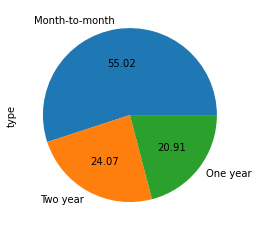

In [17]:
contract['type'].value_counts().plot.pie(autopct='%.2f', figsize=(4, 4));

Половина клиентов(55 %) платят за услуги ежемесячно, вторая половина(24% и 21 %) заключила договор на 1-2 года.

#### Безналичный расчет

In [18]:
contract['paperless_billing'].value_counts()

Yes    4171
No     2872
Name: paperless_billing, dtype: int64

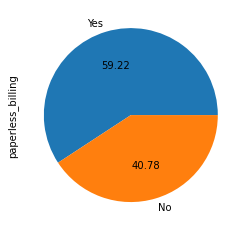

In [19]:
contract['paperless_billing'].value_counts().plot.pie(autopct='%.2f', figsize=(4, 4));

59% клиентов предпочитают безналичный расчет.

#### Способ оплаты

In [20]:
contract['payment_method'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_method, dtype: int64

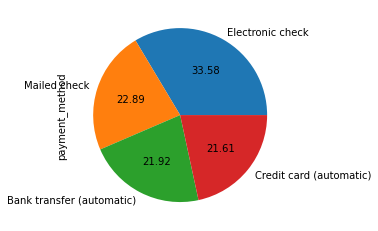

In [21]:
contract['payment_method'].value_counts().plot.pie(autopct='%.2f', figsize=(4, 4));

#### Eжемесячные траты на услуги monthly_charges

In [22]:
contract['monthly_charges'].value_counts()

20.05     61
19.85     45
19.95     44
19.90     44
20.00     43
          ..
23.65      1
114.70     1
43.65      1
87.80      1
78.70      1
Name: monthly_charges, Length: 1585, dtype: int64

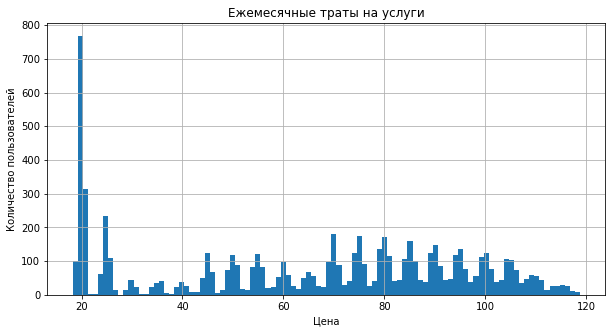

In [23]:
contract['monthly_charges'].hist(bins=100, figsize=(10, 5))
plt.xlabel('Цена')
plt.ylabel('Количество пользователей')
plt.title('Eжемесячные траты на услуги')
plt.show()

In [24]:
contract['monthly_charges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: monthly_charges, dtype: float64

Ежемесячные траты на услуги доходят до 118 единиц, минимум 18,25.

#### Всего потрачено денег на услуги total_charges

In [25]:
contract['total_charges'].value_counts()

          11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: total_charges, Length: 6531, dtype: int64

In [26]:
contract[contract['total_charges'] == ' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,


Значение ' ' присутствует в последнем месяце, который не входит в отчетный период. Заменим на 0

In [27]:
contract['total_charges'] = contract['total_charges'].replace(' ','0.0')
contract['total_charges'] = contract['total_charges'].astype('float64')

Проверим, удалось ли исправить выявленные замечания.

In [28]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


### Информация об интернет-услугах - internet

In [29]:
internet.columns

Index(['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

In [30]:
internet.rename(columns={'customerID': 'customer_id', 
                   'InternetService': 'internet_service', 
                   'OnlineSecurity': 'online_security', 
                   'OnlineBackup': 'online_backup',
                   'DeviceProtection': 'device_protection',
                   'TechSupport': 'tech_support',
                   'StreamingTV': 'streaming_tv',
                   'StreamingMovies': 'streaming_movies'}, inplace=True)

In [31]:
internet.nunique()

customer_id          5517
internet_service        2
online_security         2
online_backup           2
device_protection       2
tech_support            2
streaming_tv            2
streaming_movies        2
dtype: int64

Приведем категориальные признаки к формату category, поскольку модели LGBMRegression, CatBoostRegression не работают с типом object.

In [32]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


### Персональные данные клиента - personal

In [33]:
personal.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object')

In [34]:
personal.columns = personal.columns.str.lower()

In [35]:
personal.columns = ['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents']

In [36]:
personal.nunique()

customer_id       7043
gender               2
senior_citizen       2
partner              2
dependents           2
dtype: int64

### Информация об услугах телефонии - phone

In [37]:
phone.columns

Index(['customerID', 'MultipleLines'], dtype='object')

In [38]:
phone.rename(columns={'customerID': 'customer_id', 
                   'MultipleLines': 'multiple_lines'}, inplace=True)

### Объединение таблиц

Произведем объединение contract, internet, personal, phone в три этапа по столбцу customer_id.

In [39]:
df = contract.join(internet.set_index('customer_id'), on='customer_id', how='left')

In [40]:
df = df.join(personal.set_index('customer_id'), on='customer_id', how='left')

In [41]:
df = df.join(phone.set_index('customer_id'), on='customer_id', how='left')

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   internet_service   5517 non-null   object        
 9   online_security    5517 non-null   object        
 10  online_backup      5517 non-null   object        
 11  device_protection  5517 non-null   object        
 12  tech_support       5517 non-null   object        
 13  streaming_tv       5517 non-null   object        
 14  streamin

Проверка на пропуски

In [43]:
df.isna().sum()

customer_id             0
begin_date              0
end_date             5174
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
gender                  0
senior_citizen          0
partner                 0
dependents              0
multiple_lines        682
dtype: int64

In [44]:
df.head(10)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No
5,9305-CDSKC,2019-03-01,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50,Fiber optic,No,No,Yes,No,Yes,Yes,Female,0,No,No,Yes
6,1452-KIOVK,2018-04-01,NaT,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,Fiber optic,No,Yes,No,No,Yes,No,Male,0,No,Yes,Yes
7,6713-OKOMC,2019-04-01,NaT,Month-to-month,No,Mailed check,29.75,301.90,DSL,Yes,No,No,No,No,No,Female,0,No,No,NaN
8,7892-POOKP,2017-07-01,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05,Fiber optic,No,No,Yes,Yes,Yes,Yes,Female,0,Yes,No,Yes
9,6388-TABGU,2014-12-01,NaT,One year,No,Bank transfer (automatic),56.15,3487.95,DSL,Yes,Yes,No,No,No,No,Male,0,No,Yes,No


### Целевой признак exited

Создадим столбец c целевым признаком exited, который будет означать покинул клиент компанию или нет.

In [45]:
df['exited'] = (~df['end_date'].isna()).astype('int')

In [46]:
df['exited'].value_counts()

0    5174
1    1869
Name: exited, dtype: int64

Присутствует дисбаланс классов, необходима дальнейшая обработка при построении модели.

#### Работа с пропусками

- Поскольку все признаки с пропусками по смыслу категориальные, то при объединении возникнут незаполненные столбцы с пропусками.
- Заполним данные столбцы значением 'No'
- после заполнения поменяем тип object на category

In [47]:
df = df.fillna('No')

In [48]:
categorial = ['type', 'paperless_billing', 'payment_method', 'internet_service','online_security','online_backup','device_protection', 'tech_support', 
              'streaming_tv', 'streaming_movies', 'gender','senior_citizen','partner','dependents', 'multiple_lines']
for column in categorial:
    df[column] = df[column].astype('category')

In [49]:
df.isna().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
gender               0
senior_citizen       0
partner              0
dependents           0
multiple_lines       0
exited               0
dtype: int64

Проверим, изменили ли мы все типы данных.

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   category      
 4   paperless_billing  7043 non-null   category      
 5   payment_method     7043 non-null   category      
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   internet_service   7043 non-null   category      
 9   online_security    7043 non-null   category      
 10  online_backup      7043 non-null   category      
 11  device_protection  7043 non-null   category      
 12  tech_support       7043 non-null   category      
 13  streaming_tv       7043 non-null   category      
 14  streamin

- Поскольку мы использовали fillna, то данные в колонке end_date вернулись в исходное состояние object. 
- Повторим операцию и изменим тип данных в end_date с object на datetime64.
- Найдем длительность существования договора на момент 01.02.2020
- для этого заполним значения No на дату снятия показаний, поскольку по легенде мы выгрузили данные 01.02.2020
- найдем разницу между begin_date и end_date

In [51]:
df.loc[df['end_date'] == 'No', 'end_date'] = pd.to_datetime('2020-02-01')
df['end_date'] = pd.to_datetime(df['end_date'], format="%Y-%m-%d")

Длительность договора duration

In [52]:
df['duration'] = (df['end_date'] - df['begin_date']).dt.days

In [53]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,...,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,exited,duration
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,...,No,No,No,Female,0,Yes,No,No,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,DSL,Yes,...,No,No,No,Male,0,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,...,No,No,No,Male,0,No,No,No,1,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,...,Yes,No,No,Male,0,No,No,No,0,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,...,No,No,No,Female,0,No,No,No,1,61


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   category      
 4   paperless_billing  7043 non-null   category      
 5   payment_method     7043 non-null   category      
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   internet_service   7043 non-null   category      
 9   online_security    7043 non-null   category      
 10  online_backup      7043 non-null   category      
 11  device_protection  7043 non-null   category      
 12  tech_support       7043 non-null   category      
 13  streaming_tv       7043 non-null   category      
 14  streamin

### Исследовательский анализ данных

- Выделим числовые признаки numeric и категориальные categorial.
- total_charges исключим, поскольку для обучения модели не будем использовать данный признак

In [55]:
numeric = ['monthly_charges', 'duration']

In [56]:
categorial = ['type', 'paperless_billing', 'payment_method', 'internet_service','online_security','online_backup','device_protection', 'tech_support', 
              'streaming_tv', 'streaming_movies', 'gender','senior_citizen','partner','dependents', 'multiple_lines']

- Определим коэффициент корреляции Пирсона для каждой пары параметров при помощи функции corr(). 
- определим зависимость целевого признака exited от остальных признаков

In [57]:
df.corr().round(2)

,monthly_charges,total_charges,exited,duration
monthly_charges,1.00,0.65,0.19,0.25
total_charges,0.65,1.00,-0.20,0.83
exited,0.19,-0.20,1.00,-0.35
duration,0.25,0.83,-0.35,1.00


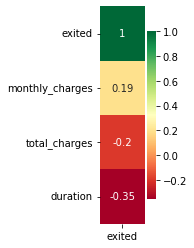

In [58]:
plt.figure(figsize=(1,4))
sns.heatmap(df.corr()[['exited']].sort_values(by='exited',
                                                               ascending=False),
                                                               cmap='RdYlGn', 
                                                               annot=True,
                                                               annot_kws={'size':10})
plt.show()

<div class='alert alert-success'> 👍	
Круто что владеешь такой мощной техникой визуализации как тепловая карта. На ней не всегда видны корреляции между признаками. В такой ситуации стоит подумать о том, что возможно признаки имеют нелинейные связи. Для выявления таких нелинейных взаимосвязей я рекомендую дополнительно посмотреть на корреляцию Спирмена, а в идеале познакомиться с очень продвинутым коэффициентом корреляции Phik. С его помощью можно получать адекватные значения корреляции для данных любой природы. https://phik.readthedocs.io/en/latest/introduction.html
   
    
Добавь еще расчет взаимосвязей между признаками, а не только с таргетом


In [59]:
df.phik_matrix()

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'exited', 'duration']


D:\soft 3\lib\site-packages\phik\data_quality.py:57: UserWarning: The number of unique values of variable customer_id is large: 7043. Are you sure this is not an interval variable? Analysis for pairs of variables including customer_id can be slow.
  warnings.warn(


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,...,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,exited,duration
customer_id,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
begin_date,1.0,1.000000,0.584146,0.766249,0.081447,0.456389,0.421886,0.819481,0.192197,0.403560,...,0.399506,0.359784,0.371863,0.011268,0.050862,0.473514,0.208564,0.428109,0.495211,0.995271
end_date,1.0,0.584146,1.000000,0.357462,0.156832,0.212169,0.319733,0.248533,0.288479,0.139392,...,0.134227,0.050373,0.047014,0.000000,0.123124,0.121753,0.133425,0.034949,1.000000,0.408477
type,1.0,0.766249,0.357462,1.000000,0.106860,0.277462,0.388444,0.505826,0.505187,0.152145,...,0.179999,0.066961,0.069608,0.000000,0.086231,0.179736,0.147680,0.065498,0.251639,0.664660
paperless_billing,1.0,0.081447,0.156832,0.106860,1.000000,0.370495,0.467812,0.207127,0.231438,0.000000,...,0.055929,0.343524,0.325551,0.000000,0.242133,0.013218,0.172593,0.252972,0.295754,0.000000
payment_method,1.0,0.456389,0.212169,0.277462,0.370495,1.000000,0.399526,0.350566,0.323886,0.262911,...,0.272101,0.377209,0.378907,0.000000,0.292725,0.243008,0.224903,0.339313,0.449125,0.375115
monthly_charges,1.0,0.421886,0.319733,0.388444,0.467812,0.399526,1.000000,0.762839,0.919002,0.551621,...,0.576525,0.835340,0.833307,0.008175,0.304985,0.203545,0.184366,0.675883,0.360050,0.411191
total_charges,1.0,0.819481,0.248533,0.505826,0.207127,0.350566,0.762839,1.000000,0.508222,0.545067,...,0.566062,0.660753,0.666609,0.000000,0.149384,0.424467,0.119077,0.606117,0.278498,0.842146
internet_service,1.0,0.192197,0.288479,0.505187,0.231438,0.323886,0.919002,0.508222,1.000000,0.241421,...,0.239663,0.272818,0.272782,0.000000,0.160702,0.000000,0.108463,0.225383,0.196202,0.019357
online_security,1.0,0.403560,0.139392,0.152145,0.000000,0.262911,0.551621,0.545067,0.241421,1.000000,...,0.528391,0.272186,0.289097,0.018397,0.057028,0.221673,0.124945,0.151886,0.264580,0.424786


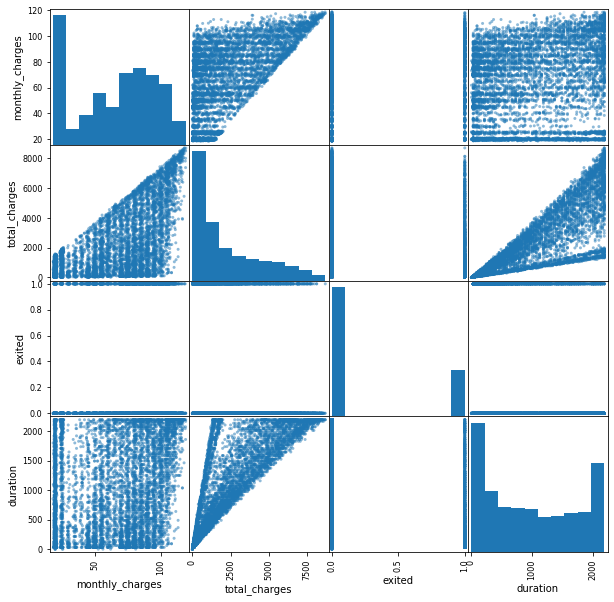

In [60]:
pd.plotting.scatter_matrix(df, figsize=(10, 10))
plt.show()

Влияние столбцов на exited уход клиентов

<AxesSubplot:ylabel='exited'>

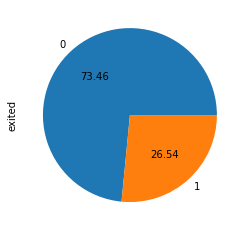

In [61]:
df['exited'].value_counts().plot.pie(autopct='%.2f')

- 73 % всех клиентов остались.
- 27 % клиентов ушли.

<AxesSubplot:>

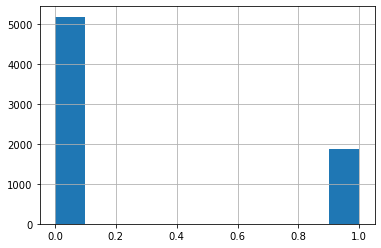

In [62]:
df['exited'].hist()

Видим сильный дисбаланс целевого признака, значит необходимо использовать балансировку class_weight

In [63]:
df[['monthly_charges','total_charges','duration']].describe()

,monthly_charges,total_charges,duration
count,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.734304,985.996166
std,30.090047,2266.794470,747.587844
min,18.250000,0.000000,0.000000
25%,35.500000,398.550000,273.000000
50%,70.350000,1394.550000,883.000000
75%,89.850000,3786.600000,1676.000000
max,118.750000,8684.800000,2191.000000


<AxesSubplot:>

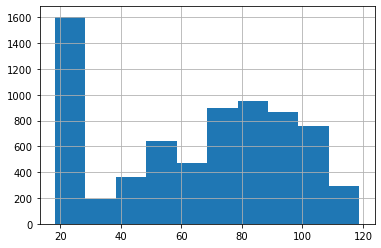

In [64]:
df['monthly_charges'].hist()

<AxesSubplot:>

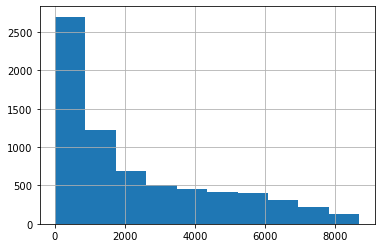

In [65]:
df['total_charges'].hist()

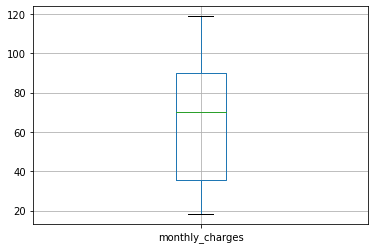

In [66]:
df.boxplot(column='monthly_charges')
plt.show()

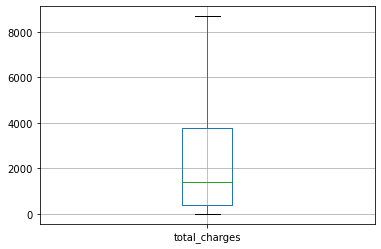

In [67]:
df.boxplot(column='total_charges')
plt.show()

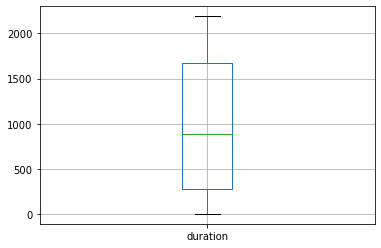

In [68]:
df.boxplot(column='duration')
plt.show()

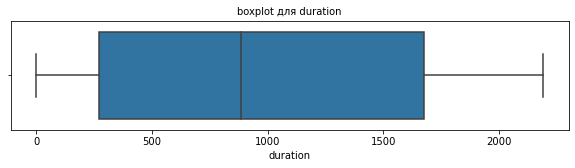

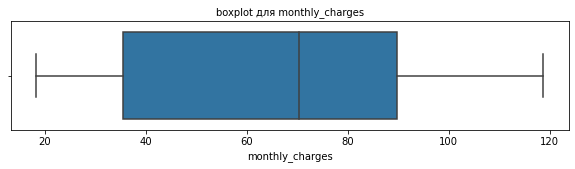

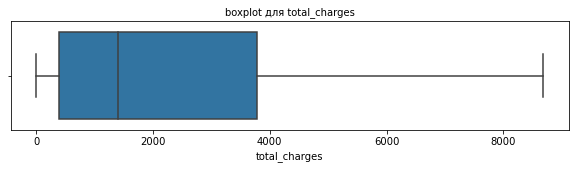

In [69]:
cols_numeric = ['duration', 'monthly_charges', 'total_charges']
for col in cols_numeric:
    plt.figure(figsize=(10,2))
    plt.title('boxplot для ' + col, fontsize=10)
    ax = sns.boxplot(x=col, data=df)
    plt.show()

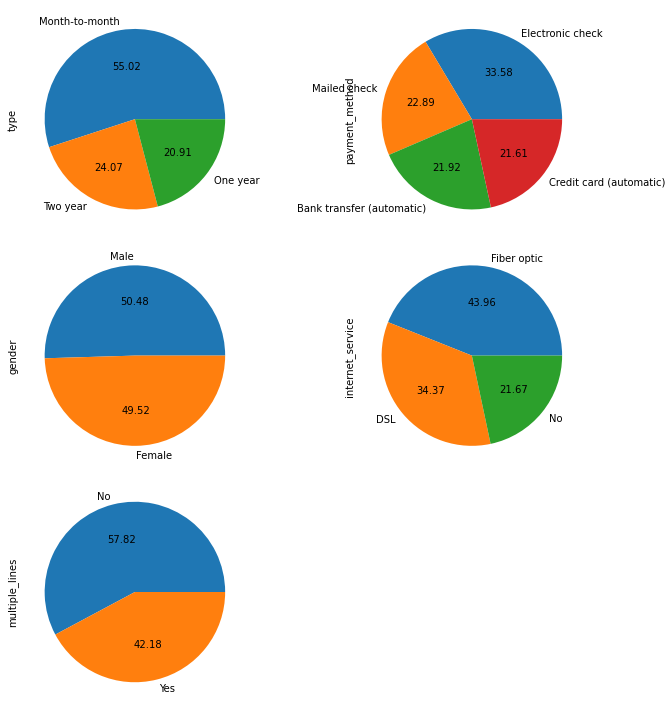

In [70]:
f, axes = plt.subplots(3, 2, figsize=(10, 10))
f.delaxes(axes[2,1])
df['type'].value_counts().plot.pie(autopct='%.2f', ax=axes[0, 0]);
df['payment_method'].value_counts().plot.pie(autopct='%.2f', ax=axes[0, 1]);
df['gender'].value_counts().plot.pie(autopct='%.2f', ax=axes[1, 0]);
df['internet_service'].value_counts().plot.pie(autopct='%.2f', ax=axes[1, 1]);
df['multiple_lines'].value_counts().plot.pie(autopct='%.2f', ax=axes[2, 0]);
f.tight_layout()

### Моделирование


#### Подготовка признаков

Удалим лишние признаки для модели.

In [71]:
df.drop(columns=['customer_id', 'begin_date', 'end_date', 'total_charges'], inplace=True)

# проверка
df.head() 

,type,paperless_billing,payment_method,monthly_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,exited,duration
0,Month-to-month,Yes,Electronic check,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,No,0,31
1,One year,No,Mailed check,56.95,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No,0,1036
2,Month-to-month,Yes,Mailed check,53.85,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No,1,61
3,One year,No,Bank transfer (automatic),42.30,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,No,0,1371
4,Month-to-month,Yes,Electronic check,70.70,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No,1,61


Подготовим выборки для обучения следующих моделей:
- CatBoostClassifier,
- LinearClassifier,
- LGBMClassifier

Для каждой модели попробуем разные гиперпараметры.

### Разбиение данных на выборки

- Целевой признак, то есть признак, который необходимо определить - это столбец exited.
- Признаками в исходных данных являются остальные столбцы.

In [72]:
features = df.drop('exited', axis=1)
target = df['exited']

- Разделим данные на обучающую и тестовую выборки в пропорции 3:1 соответственно 
- (75% на обучающую и 25% данных на тестовую выборки).

In [73]:
# разделениe на обучающую выборку features_train и  тестовую features_test
# отделяем 25% данных для тестовой выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE) 

print('Размер обучающей выборки:', features_train.shape[0],'объектов')
print('Размер тестовой выборки:', features_test.shape[0],'объектов')

Размер обучающей выборки: 5282 объектов
Размер тестовой выборки: 1761 объектов


In [74]:
# получилось одинаковое количество признаков
features_train.shape, features_test.shape

((5282, 17), (1761, 17))

In [75]:
features_train_lr = features_train.copy()
features_test_lr = features_test.copy()

target_train_lr = target_train.copy()
target_test_lr = target_test.copy()

### Масштабирование признаков

Чтобы алгоритмам было легче обучать модели, числовые признаки приводятся к одному масштабу. Один из методов масштабирования — стандартизация данных. В sklearn есть отдельная структура для стандартизации данных — StandardScaler (от англ. «преобразователь масштаба методом стандартизации»)

In [76]:
scaler = StandardScaler()

In [77]:
import warnings
warnings.filterwarnings('ignore')

# обучаем на тренировочной выборке
scaler.fit(features_train_lr[numeric])

features_train_lr[numeric] = scaler.transform(features_train_lr[numeric])
features_test_lr[numeric] = scaler.transform(features_test_lr[numeric])

#проверяем маштабирование
features_train_lr.head(6)

,type,paperless_billing,payment_method,monthly_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,duration
371,Month-to-month,Yes,Electronic check,0.717486,Fiber optic,No,No,No,No,Yes,No,Male,0,No,No,Yes,-1.229095
5715,Month-to-month,Yes,Credit card (automatic),1.467257,Fiber optic,Yes,Yes,No,Yes,Yes,Yes,Male,0,No,No,Yes,-0.004084
1444,Two year,Yes,Electronic check,1.567226,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Male,0,No,Yes,No,0.363553
4928,Month-to-month,No,Electronic check,-0.603775,DSL,No,No,No,No,No,No,Female,1,Yes,Yes,No,-1.147248
6915,Two year,Yes,Electronic check,1.124028,Fiber optic,No,No,Yes,No,Yes,Yes,Female,0,Yes,No,Yes,1.628815
4595,Two year,No,Bank transfer (automatic),0.705823,DSL,No,Yes,Yes,Yes,Yes,Yes,Female,0,Yes,Yes,Yes,1.467806


### Преобразование признаков

Кодирование с помощью OHE

Поскольку в данных присутствуют категориальные и количественные признаки, то оптимальной техникой кодирования для модели линейной регрессии будет One-Hot Encoding (далее OHE). Ordinal Encoding нам не подходит, поскольку используется только для категориальных признаков.

In [78]:
#drop='first' удаляет первый признак из закодированных:
#таким образом обходим dummy-ловушку
#задаём handle_unknown='ignore':
#игнорируется ранее невстречающиеся значения признака (при transform)

In [79]:
enc = OneHotEncoder(drop='first', sparse=False)
#, handle_unknown='ignore' #вылезает ошибка

#обучаем энкодер на заданных категориальных признаках тренировочной выборки
#добавляем закодированные признаки в result_train
#enc.get_feature_names_out() позволяет получить названия колонок
result_train = enc.fit_transform(features_train_lr[categorial])
result_train = pd.DataFrame(result_train, columns=enc.get_feature_names(categorial), index=features_train.index)
result_train = result_train.join(features_train_lr[numeric])
result_train.head()

,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,internet_service_Fiber optic,internet_service_No,online_security_Yes,online_backup_Yes,...,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,gender_Male,senior_citizen_1,partner_Yes,dependents_Yes,multiple_lines_Yes,monthly_charges,duration
371,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.717486,-1.229095
5715,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.467257,-0.004084
1444,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.567226,0.363553
4928,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,-0.603775,-1.147248
6915,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.124028,1.628815


In [80]:
result_test = enc.transform(features_test_lr[categorial])

result_test = pd.DataFrame(result_test, columns=enc.get_feature_names(categorial), index=features_test_lr.index)
result_test = result_test.join(features_test_lr[numeric])
result_test.head()

,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,internet_service_Fiber optic,internet_service_No,online_security_Yes,online_backup_Yes,...,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,gender_Male,senior_citizen_1,partner_Yes,dependents_Yes,multiple_lines_Yes,monthly_charges,duration
176,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.344267,-0.697765
5084,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-1.445184,-0.410632
3412,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,-0.153913,-1.227753
4649,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.493915,1.628815
6482,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.243992,-1.270689


In [81]:
#добавляем remainder='passthrough
col_transformer_lr = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        features_train_lr[categorial]
    ),
    (
        StandardScaler(), 
        features_train_lr[numeric]
    ),
    remainder='passthrough'
)

### LogisticRegression

In [82]:
model_lr = LogisticRegression(solver='liblinear', random_state=RANDOM_STATE, class_weight = 'balanced')

In [83]:
cv_results = cross_validate(model_lr, result_train, target_train_lr, scoring='roc_auc', cv=5)

In [84]:
cv_results

{'fit_time': array([0.07695055, 0.02864742, 0.03021169, 0.03222799, 0.02010202]),
 'score_time': array([0.02598548, 0.02011991, 0.01808858, 0.01434064, 0.01004648]),
 'test_score': array([0.84300423, 0.83220031, 0.83479842, 0.84067102, 0.84716975])}

In [85]:
fit_time = cv_results['fit_time'].mean()
score_time = cv_results['score_time'].mean()
test_score = abs(cv_results['test_score'].mean())

print('Время обучения: {},  время предсказания: {} и качество модели метрика roc_auc_score: {}'.format(fit_time.round(3), score_time.round(3), test_score.round(3)))

Время обучения: 0.038,  время предсказания: 0.018 и качество модели метрика roc_auc_score: 0.84


In [86]:
# обучим модель на тренировочной выборке
model_lr.fit(result_train, target_train_lr)

LogisticRegression(class_weight='balanced', random_state=121222,
                   solver='liblinear')

In [87]:
# получим предсказания модели на тестовой выборке
predictions_lr = model_lr.predict(result_test)

In [88]:
# проверка
accuracy_valid = accuracy_score(predictions_lr, target_test_lr)

In [89]:
print('Доля правильных ответов Accuracy на тесте:', accuracy_valid)

Доля правильных ответов Accuracy на тесте: 0.75809199318569


In [90]:
print('Проверка модели LogisticRegression на тесте. Метрика roc_auc_score:', roc_auc_score(target_test_lr, predictions_lr))

Проверка модели LogisticRegression на тесте. Метрика roc_auc_score: 0.7808889694612458


In [91]:
type(predictions_lr)

numpy.ndarray

In [92]:
type(target_test_lr)

pandas.core.series.Series

### LGBMClassifier

Для обучения модели LGBMClassifier можно не применять технологию OneHotEncoder для работы с категориальными данными. Подготовим выборку для моделей бустинга.

In [93]:
features_train_boost, features_test_boost, target_train_boost, target_test_boost = train_test_split(
                                      features, target, test_size=0.25, random_state = RANDOM_STATE)

print('Размер таблицы признаков обучающей выборки: ', features_train_boost.shape)
print('Размер таблицы признаков тестовой выборки: ', features_test_boost.shape)

Размер таблицы признаков обучающей выборки:  (5282, 17)
Размер таблицы признаков тестовой выборки:  (1761, 17)


In [94]:
scaler.fit(features_train_boost[numeric])

features_train_boost[numeric] = scaler.transform(features_train_boost[numeric])
features_test_boost[numeric] = scaler.transform(features_test_boost[numeric])

features_train_boost.head()

,type,paperless_billing,payment_method,monthly_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,duration
371,Month-to-month,Yes,Electronic check,0.717486,Fiber optic,No,No,No,No,Yes,No,Male,0,No,No,Yes,-1.229095
5715,Month-to-month,Yes,Credit card (automatic),1.467257,Fiber optic,Yes,Yes,No,Yes,Yes,Yes,Male,0,No,No,Yes,-0.004084
1444,Two year,Yes,Electronic check,1.567226,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Male,0,No,Yes,No,0.363553
4928,Month-to-month,No,Electronic check,-0.603775,DSL,No,No,No,No,No,No,Female,1,Yes,Yes,No,-1.147248
6915,Two year,Yes,Electronic check,1.124028,Fiber optic,No,No,Yes,No,Yes,Yes,Female,0,Yes,No,Yes,1.628815


In [95]:
model_lgbmc = LGBMClassifier(silent=True, class_weight = 'balanced')

In [96]:
parameters = {'boosting_type': 'gbdt', 'random_state': RANDOM_STATE }

In [97]:
model_lgbmc = LGBMClassifier(**parameters)

In [98]:
params_lgbmc = [{'learning_rate': [0.1, 0.5],
                 'max_depth': [10, 50, 100],
                       'n_estimators': [100, 200],
                       }]

grid_search_lgbmc = GridSearchCV(model_lgbmc, 
                        params_lgbmc, 
                        cv = 5, 
                        verbose = 0, 
                        n_jobs=-1,
                        scoring='roc_auc')

In [99]:
%%time
grid_search_lgbmc.fit(features_train_boost, target_train_boost)

Wall time: 23.8 s


GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=121222), n_jobs=-1,
             param_grid=[{'learning_rate': [0.1, 0.5],
                          'max_depth': [10, 50, 100],
                          'n_estimators': [100, 200]}],
             scoring='roc_auc')

- Смотрим результаты

In [100]:
grid_search_lgbmc.cv_results_

{'mean_fit_time': array([0.37415977, 0.67265739, 0.45227385, 0.55306454, 0.35440903,
        0.67961049, 0.34388013, 0.49310613, 0.32004561, 0.46197882,
        0.30949912, 0.46270938]),
 'std_fit_time': array([0.05784939, 0.16369631, 0.13563304, 0.14673169, 0.06158502,
        0.13188295, 0.08878246, 0.12215896, 0.08595319, 0.03932104,
        0.05972426, 0.11508966]),
 'mean_score_time': array([0.27834072, 0.26241484, 0.21858177, 0.22481995, 0.19231482,
        0.37709165, 0.21048827, 0.21712122, 0.1370553 , 0.11940317,
        0.13349252, 0.19977188]),
 'std_score_time': array([0.15689947, 0.1083073 , 0.06173852, 0.10323506, 0.11329582,
        0.22202468, 0.14175277, 0.07772819, 0.04866074, 0.0340417 ,
        0.04587228, 0.12186625]),
 'param_learning_rate': masked_array(data=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.5, 0.5, 0.5, 0.5, 0.5,
                    0.5],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
 

- Выбираем лучший индекс

In [101]:
best_index = grid_search_lgbmc.best_index_

In [102]:
fit_time_grid = grid_search_lgbmc.cv_results_['mean_fit_time'][best_index]
score_time_grid = grid_search_lgbmc.cv_results_['mean_score_time'][best_index]
test_score_grid = abs(grid_search_lgbmc.cv_results_['mean_test_score'][best_index])

print('Время обучения: {},  время предсказания: {} и качество модели: {}'.format(fit_time_grid.round(3), score_time_grid.round(3), test_score_grid.round(3)))

Время обучения: 0.673,  время предсказания: 0.262 и качество модели: 0.896


In [103]:
print('roc_auc:')
grid_search_lgbmc.cv_results_['mean_test_score'][best_index].round(3)

roc_auc:


0.896

In [104]:
best_parameters_lgbmc = grid_search_lgbmc.best_params_

In [105]:
best_parameters_lgbmc

{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}

In [106]:
lgbmc_model = lgb.LGBMClassifier(**best_parameters_lgbmc, random_state=RANDOM_STATE)

In [107]:
lgbmc_model.fit(features_train_boost, target_train_boost)

LGBMClassifier(max_depth=10, n_estimators=200, random_state=121222)

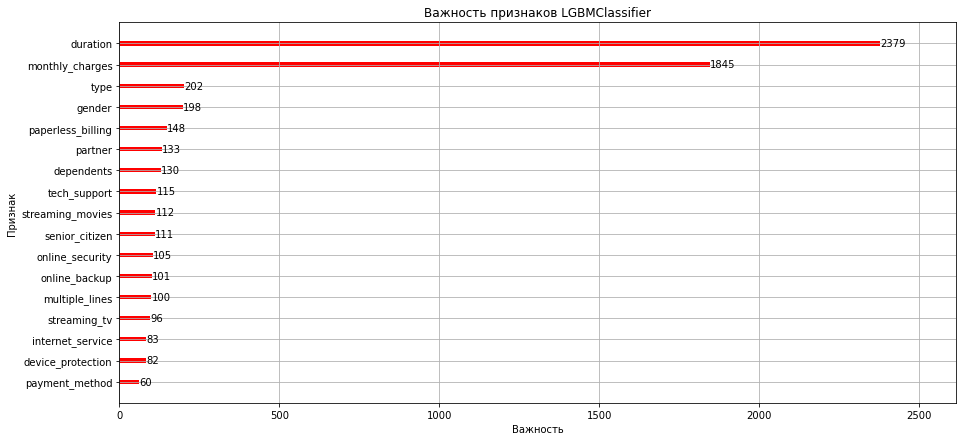

In [108]:
ax0 = lgb.plot_importance(lgbmc_model, color='r', title='Важность признаков LGBMClassifier', xlabel='Важность', ylabel='Признак', figsize=(15,7))

### Вывод

- Модель: **LGBMClassifier**
- Время обучения: **0.495 c**
- Скорость предсказания: **0.198 c**
- Метрика roc_auc: **0.896**

По условиям задачи значение метрики roc_auc должно быть не меньше 0,75. Модель **model_cbr** построенная при помощи градиентного бустинга LGBMClassifier нам подходит, поскольку удовлетворяет условиям задачи.

### Модель бустинга CatBoostClassifier

In [109]:
model_cbc = CatBoostClassifier(loss_function='Logloss', random_state=RANDOM_STATE)

params_catboost = [{'learning_rate': [0.2, 0.5],
                    'depth': [1, 5, 10],
                   'iterations': [100, 200]}]

grid_cbc = GridSearchCV(model_cbc, 
                        params_catboost, 
                        cv = 5, 
                        verbose = 0, 
                        n_jobs=-1,
                        scoring='roc_auc')

In [110]:
grid_cbc.fit(features_train_lr, target_train_lr, cat_features=categorial) 

0:	learn: 0.5046053	total: 165ms	remaining: 32.8s
1:	learn: 0.4346008	total: 190ms	remaining: 18.8s
2:	learn: 0.4079448	total: 220ms	remaining: 14.4s
3:	learn: 0.3993506	total: 245ms	remaining: 12s
4:	learn: 0.3962055	total: 259ms	remaining: 10.1s
5:	learn: 0.3925740	total: 286ms	remaining: 9.25s
6:	learn: 0.3900012	total: 315ms	remaining: 8.69s
7:	learn: 0.3862138	total: 342ms	remaining: 8.21s
8:	learn: 0.3862137	total: 350ms	remaining: 7.42s
9:	learn: 0.3727528	total: 378ms	remaining: 7.18s
10:	learn: 0.3712432	total: 404ms	remaining: 6.93s
11:	learn: 0.3704136	total: 456ms	remaining: 7.14s
12:	learn: 0.3704135	total: 465ms	remaining: 6.69s
13:	learn: 0.3671570	total: 504ms	remaining: 6.7s
14:	learn: 0.3647838	total: 542ms	remaining: 6.68s
15:	learn: 0.3624179	total: 581ms	remaining: 6.68s
16:	learn: 0.3616467	total: 614ms	remaining: 6.61s
17:	learn: 0.3615937	total: 651ms	remaining: 6.58s
18:	learn: 0.3558131	total: 699ms	remaining: 6.66s
19:	learn: 0.3520322	total: 744ms	remaining:

163:	learn: 0.1588711	total: 4.81s	remaining: 1.05s
164:	learn: 0.1578129	total: 4.83s	remaining: 1.02s
165:	learn: 0.1573486	total: 4.86s	remaining: 995ms
166:	learn: 0.1567121	total: 4.88s	remaining: 964ms
167:	learn: 0.1563260	total: 4.9s	remaining: 934ms
168:	learn: 0.1561161	total: 4.93s	remaining: 904ms
169:	learn: 0.1554372	total: 4.95s	remaining: 873ms
170:	learn: 0.1551107	total: 4.97s	remaining: 843ms
171:	learn: 0.1548637	total: 5s	remaining: 813ms
172:	learn: 0.1537972	total: 5.04s	remaining: 786ms
173:	learn: 0.1535759	total: 5.07s	remaining: 758ms
174:	learn: 0.1533309	total: 5.11s	remaining: 730ms
175:	learn: 0.1527687	total: 5.15s	remaining: 702ms
176:	learn: 0.1522974	total: 5.18s	remaining: 674ms
177:	learn: 0.1507723	total: 5.23s	remaining: 646ms
178:	learn: 0.1499769	total: 5.27s	remaining: 618ms
179:	learn: 0.1496876	total: 5.31s	remaining: 590ms
180:	learn: 0.1486160	total: 5.33s	remaining: 560ms
181:	learn: 0.1482766	total: 5.35s	remaining: 530ms
182:	learn: 0.14

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001BBB4CD67F0>,
             n_jobs=-1,
             param_grid=[{'depth': [1, 5, 10], 'iterations': [100, 200],
                          'learning_rate': [0.2, 0.5]}],
             scoring='roc_auc')

In [111]:
grid_cbc.cv_results_

{'mean_fit_time': array([ 1.37000813,  1.32721195,  3.32946377,  4.51570263,  5.22252741,
         4.92112627,  6.62981925,  6.01751466,  7.00576782,  7.7072113 ,
        26.29719057, 31.69491158]),
 'std_fit_time': array([0.15877904, 0.10774089, 0.25106392, 1.44674682, 1.89405074,
        1.67300904, 0.89406256, 0.65503418, 0.18402122, 0.62613087,
        4.75697832, 4.7285409 ]),
 'mean_score_time': array([0.01770797, 0.02775826, 0.01930017, 0.02375717, 0.03998823,
        0.03359008, 0.0116066 , 0.01166358, 0.015694  , 0.01466537,
        0.04433312, 0.03899436]),
 'std_score_time': array([0.00692087, 0.01267844, 0.00097974, 0.00761945, 0.01658423,
        0.00479829, 0.00444912, 0.00320525, 0.00466677, 0.00409627,
        0.02119225, 0.01869147]),
 'param_depth': masked_array(data=[1, 1, 1, 1, 5, 5, 5, 5, 10, 10, 10, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
             

In [112]:
best_index_cbc = grid_cbc.best_index_
fit_time_cbc = grid_cbc.cv_results_['mean_fit_time'][best_index_cbc]
score_time_cbc = grid_cbc.cv_results_['mean_score_time'][best_index_cbc]
test_score_cbc = abs(grid_cbc.cv_results_['mean_test_score'][best_index_cbc])

print('Время обучения: {},  время предсказания: {} и качество модели: {}'.format(fit_time_cbc.round(3), score_time_cbc.round(3), test_score_cbc.round(3)))

Время обучения: 6.018,  время предсказания: 0.012 и качество модели: 0.913


In [113]:
best_params_cbc = grid_cbc.best_params_

In [114]:
best_params_cbc

{'depth': 5, 'iterations': 200, 'learning_rate': 0.5}

In [115]:
cbc_model = CatBoostClassifier(random_seed=RANDOM_STATE, **best_params_cbc)

In [116]:
cbc_model.fit(features_train_boost, target_train_boost, cat_features=categorial)

0:	learn: 0.5046053	total: 42.1ms	remaining: 8.38s
1:	learn: 0.4346008	total: 104ms	remaining: 10.3s
2:	learn: 0.4079448	total: 137ms	remaining: 9.02s
3:	learn: 0.3993506	total: 176ms	remaining: 8.63s
4:	learn: 0.3962055	total: 202ms	remaining: 7.89s
5:	learn: 0.3925740	total: 236ms	remaining: 7.63s
6:	learn: 0.3900012	total: 279ms	remaining: 7.7s
7:	learn: 0.3862138	total: 320ms	remaining: 7.68s
8:	learn: 0.3862137	total: 328ms	remaining: 6.97s
9:	learn: 0.3727528	total: 366ms	remaining: 6.95s
10:	learn: 0.3712432	total: 402ms	remaining: 6.9s
11:	learn: 0.3704136	total: 438ms	remaining: 6.86s
12:	learn: 0.3704135	total: 449ms	remaining: 6.46s
13:	learn: 0.3671570	total: 485ms	remaining: 6.45s
14:	learn: 0.3647838	total: 512ms	remaining: 6.31s
15:	learn: 0.3624179	total: 536ms	remaining: 6.17s
16:	learn: 0.3616467	total: 557ms	remaining: 6s
17:	learn: 0.3615937	total: 575ms	remaining: 5.82s
18:	learn: 0.3558131	total: 614ms	remaining: 5.85s
19:	learn: 0.3520322	total: 663ms	remaining: 

166:	learn: 0.1567121	total: 4.66s	remaining: 921ms
167:	learn: 0.1563260	total: 4.7s	remaining: 895ms
168:	learn: 0.1561161	total: 4.73s	remaining: 868ms
169:	learn: 0.1554372	total: 4.76s	remaining: 840ms
170:	learn: 0.1551107	total: 4.79s	remaining: 812ms
171:	learn: 0.1548637	total: 4.82s	remaining: 784ms
172:	learn: 0.1537972	total: 4.84s	remaining: 756ms
173:	learn: 0.1535759	total: 4.87s	remaining: 728ms
174:	learn: 0.1533309	total: 4.89s	remaining: 699ms
175:	learn: 0.1527687	total: 4.92s	remaining: 671ms
176:	learn: 0.1522974	total: 4.95s	remaining: 643ms
177:	learn: 0.1507723	total: 4.97s	remaining: 615ms
178:	learn: 0.1499769	total: 5.01s	remaining: 588ms
179:	learn: 0.1496876	total: 5.04s	remaining: 560ms
180:	learn: 0.1486160	total: 5.07s	remaining: 532ms
181:	learn: 0.1482766	total: 5.09s	remaining: 503ms
182:	learn: 0.1477328	total: 5.11s	remaining: 475ms
183:	learn: 0.1468764	total: 5.14s	remaining: 447ms
184:	learn: 0.1462415	total: 5.22s	remaining: 423ms
185:	learn: 0

#### График важности признаков для лучшей модели

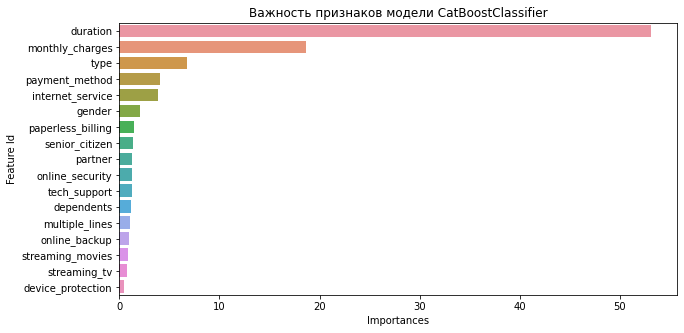

In [117]:
feature_importances = cbc_model.get_feature_importance(prettified=True)

plt.figure(figsize=(10, 5));
sns.barplot(x="Importances", y="Feature Id", data=feature_importances);
plt.title('Важность признаков модели CatBoostClassifier');

- Модель определила самые важные признаки - duration (длительность контракта с клиентом)
- Следующий по важности фактор MonthlyCharges – ежемесячные траты на услуги
- Третий по важности фактор - type (two year) - тип оплаты: ежемесячный, годовой и тд

### Вывод

- Модель: **CatBoostClassifier**
- Время обучения: **5.879**
- Скорость предсказания: **0.011 c**
- Метрика roc_auc: **0.913**

По условиям задачи значение метрики roc_auc должно быть не меньше 0,75. Модель **model_cbc** построенная при помощи градиентного бустинга CatBoostClassifier нам подходит, поскольку удовлетворяет условиям задачи. Из всех моделей по показателям метрики roc_auc оказалась лучшей, поэтому на ней будем проводить тестирование.

Наблюдаем, что метрика roc_auc_score для DummyClassifier оказалась значительно хуже, чем у остальных моделей.

### Тестирование 

In [118]:
result_test = enc.transform(features_test_boost[categorial])

result_test = pd.DataFrame(result_test, columns=enc.get_feature_names(categorial), index=features_test_boost.index)
result_test = result_test.join(features_test_boost[numeric])
result_test.head()

,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,internet_service_Fiber optic,internet_service_No,online_security_Yes,online_backup_Yes,...,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,gender_Male,senior_citizen_1,partner_Yes,dependents_Yes,multiple_lines_Yes,monthly_charges,duration
176,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.344267,-0.697765
5084,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-1.445184,-0.410632
3412,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,-0.153913,-1.227753
4649,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.493915,1.628815
6482,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.243992,-1.270689


In [119]:
%%time
predictions_cbc = grid_cbc.predict(features_test_lr)

Wall time: 13 ms


In [120]:
accuracy_test = accuracy_score(predictions_cbc, target_test_lr)
print('accuracy_test на тестовой выборке:', accuracy_test.round(3))

accuracy_test на тестовой выборке: 0.873


In [121]:
predictions_cbc_test = cbc_model.predict_proba(features_test_lr)

In [122]:
probabilities_valid = cbc_model.predict_proba(features_test_lr)
probabilities_one_valid = probabilities_valid[:, 1]

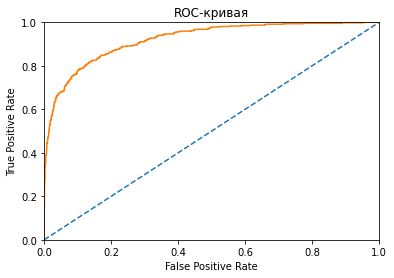

In [123]:
fpr, tpr, thresholds = roc_curve(target_test_lr, probabilities_one_valid)

plt.figure()

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)

#   установить границы осей от 0 до 1 >
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая')
plt.show()

In [124]:
print('Метрика roc_auc_score модели CatBoostClassifier на тестовой выборке:')

Метрика roc_auc_score модели CatBoostClassifier на тестовой выборке:


In [125]:
auc_roc = roc_auc_score(target_test_lr, probabilities_one_valid)

print(auc_roc)

0.921818811081629


### Проверка DummyClassifier

In [126]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='stratified')

dummy.fit(features_train_lr, target_train_lr)

predictions_dummy = dummy.predict(features_test_lr)

roc_auc_score = roc_auc_score(target_test_lr, predictions_dummy)

print('roc_auc_score DummyClassifier на тестовой выборке:', roc_auc_score)

roc_auc_score DummyClassifier на тестовой выборке: 0.4992633122929611


### Выводы

- В проектной работе открыты, проанализированы данные, произведена проверка на наличие дубликатов, пропуски и дисбаланс классов
- Исходные таблицы сведены в одну, убраны пропуски, изменены типы данных
- Проведен исследовательский анализ данных.
- Таблица содержит в себе контракты начиная с октября 2013 года до февраля 2020.
- В конце 2019 года происходил массовый отток клиентов 4 месяца подряд.
- Половина клиентов(55 %) платят за услуги ежемесячно, вторая половина(24% и 21 %) заключила договор на 1-2 года.
- 59% клиентов предпочитают безналичный расчет.
- Ежемесячные траты на услуги доходят до 118 единиц, минимум 18,25.
- 27 % клиентов перестали пользоваться услугами компании.
- Обработаны признаки с помощью OneHotEncoder, StandardScaler
- Удалены лишние для машинного обучения столбцы ('customer_id', 'begin_date', 'end_date', 'total_charges')
- Обучены модели LogisticRegression, CatBoostClassifier, LGBMClassifier.
- Произведена проверка DummyClassifier
- Лучшие результаты метрики roc_auc = 0.91 и accuracy = 0.873 у CatBoostClassifier
- Лучшие параметры CatBoostClassifier: {'depth': 5, 'iterations': 200, 'learning_rate': 0.5}
- Модель определила самые важные признаки - duration (длительность контракта с клиентом)
- Следующий по важности фактор MonthlyCharges – ежемесячные траты на услуги
- Третий по важности фактор - type (two year) - тип оплаты: ежемесячный, годовой и тд

### Отчёт

#### Какие пункты плана были выполнены, а какие — нет (поясните почему)?

Все пункты плана были выполнены.

#### Исследовательский анализ данных
- Первичное знакомство / загрузка данных
- Информация о договоре – contract
- Тип оплаты: ежемесячный, годовой и двухгодовой
- Безналичный расчет
- Способ оплаты
- Eжемесячные траты на услуги monthly_charges
- Всего потрачено денег на услуги total_charges
- Информация об интернет-услугах – internet
- Персональные данные клиента – personal
- Информация об услугах телефонии – phone
- Объединение таблиц
- Целевой признак exited
- Работа с пропусками
- Исследовательский анализ данных
#### Моделирование
- Подготовка признаков
- Разбиение данных на выборки
- Масштабирование признаков StandardScaler
- Преобразование признаков с помощью OHE
- LogisticRegression
- LGBMClassifier
- Модель бустинга CatBoostClassifier
- График важности признаков для лучшей модели
#### Тестирование
- Проверка DummyClassifier

#### Какие трудности возникли и как вы их преодолели?

- Возникала ошибка TypeError: 'numpy.float64' object is not callable при вычислении roc_auc_score() .
- roc_curve была построена некорректно
- По всей видимости ошибка возникала потому, что некорректно обработанные данные подавал в модель и в roc_auc_score
- Изучение теории в тренажере для построения roc_curve 

#### Какие ключевые шаги в решении задачи выделили?

- Составление плана работ
- Исследовательский анализ данных
    - Первичное знакомство / загрузка данных
    - Сборка единой таблицы
    - Извлечение целевого признака
    - Получение нового признака
    - Анализ корреляции между признаками
- Моделирование 
    - Подготовка признаков(удаление лишних)
    - Разбиение данных на выборки
    - Масштабирование признаков StandardScaler
    - Преобразование признаков с помощью OHE
    - Оптимизация гиперпараметров моделей
    - Анализ важности признаков лучших моделей
    - Выбор и тестирование лучшей модели;
    - Проверка DummyClassifier
- Составление вывода.

#### Какая ваша итоговая модель и какое у неё качество?

- Лучшая модель CatBoostClassifier model_cbc = CatBoostClassifier(loss_function='Logloss', random_state=121222)

- Лучшие параметры модели CatBoostClassifier: best_params_cbc = [{'learning_rate': [0.5],
                    'depth': [5],
                   'iterations': [200]}]
- Для поиска лучших гиперпараметров был использован готовый алгоритм GridSearchCV.

- grid_cbc = GridSearchCV(model_cbc, 
                        best_params_cbc, 
                        cv = 5, 
                        verbose = 0, 
                        n_jobs=-1,
                        scoring='roc_auc')
- Лучшие гиперпараметры выбраны параметром grid_cbc.best_params_
- Модель обучалась на обучающей выборке features_train, target_train, test_size=0.25 (25% данных оставлены для тестовой выборки), также для обучения были указаны все категориальные признаки cat_features=categorial
- Лучшие результаты метрики roc_auc_score = 0.91 и accuracy = 0.87